In [117]:
import os
import shutil
import vcf
import re
import gzip
import pandas as pd
import yaml
import subprocess
import matplotlib.pyplot as plt


from IPython.display import Image
from Bio import SeqIO


import rpy2.ipython


%load_ext rpy2.ipython

os.chdir("/master/nplatt/sch_man_nwinvasion")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Linkage Disequilibrium

In [14]:
if not os.path.isdir("results/ld"):
    os.mkdir("results/ld")

In [17]:
with open('data/pop_assign.yml') as yaml_file:
    pop_assign = yaml.load(yaml_file, Loader=yaml.FullLoader)

for pop in set(pop_assign.values()):
    list_file = "results/ld/{}.list".format(pop);
    if os.path.exists(list_file):
        os.remove(list_file)

In [122]:
for pop in set(pop_assign.values()):
    list_file = "results/ld/{}.list".format(pop);
    if os.path.exists(list_file):
        os.remove(list_file)
    
for sample in pop_assign:
   
    pop=pop_assign[sample]
    list_file="results/ld/" + pop + ".list"
    with open(list_file, 'a') as filehandle:
        filehandle.write("{}\n".format(sample))

In [ ]:
in_vcf="results/variant_filtration/smv7_ex_autosomes.vcf"

for pop in ["senegal", "niger", "brazil", "tanzania"]:
    in_list = "results/ld/{}.list".format(pop)
    
    for chrom in list(range(1, 8)):
        chrom="SM_V7_{}".format(chrom)
        out_vcf = "results/ld/smv7_ex_autosomes_{}_{}.vcf".format(pop, chrom)
        
        #get ld chrom vcf
        vcf_cmd="vcftools --vcf {} --mac 1 --chr {} --keep {} --recode --recode-INFO-all --stdout >{}".format(in_vcf, chrom, in_list, out_vcf)
        !{vcf_cmd}

        #convert vcf to plink
        plink_prefix="results/ld/smv7_ex_autosomes_{}_{}".format(pop, chrom)
        plink_cmd="plink --threads 6 --vcf {} --out {} --double-id --recode12 --allow-extra-chr".format(out_vcf, plink_prefix)
        !{plink_cmd}  
        
        #calculate R2 between all snps on a chr
        plink_cmd="plink --threads 6 --r2 --file {} --out {} --double-id --allow-extra-chr --ld-window-r2 0.0 --ld-window 1000000 --ld-window-kb 90000".format(plink_prefix, plink_prefix)
        !{plink_cmd}


PLINK v1.90b6.18 64-bit (16 Jun 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Note: --recode12 flag deprecated.  Use "--recode 12 ...".
Logging to results/ld/smv7_ex_autosomes_senegal_SM_V7_1.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --out results/ld/smv7_ex_autosomes_senegal_SM_V7_1
  --recode 12
  --threads 6
  --vcf results/ld/smv7_ex_autosomes_senegal_SM_V7_1.vcf

160778 MB RAM detected; reserving 80389 MB for main workspace.
--vcf: results/ld/smv7_ex_autosomes_senegal_SM_V7_1-temporary.bed +
results/ld/smv7_ex_autosomes_senegal_SM_V7_1-temporary.bim +
results/ld/smv7_ex_autosomes_senegal_SM_V7_1-temporary.fam written.
9381 variants loaded from .bim file.
25 people (0 males, 0 females, 25 ambiguous) loaded from .fam.
Ambiguous sex IDs written to results/ld/smv7_ex_autosomes_senegal_SM_V7_1.nosex
.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 25 f

results/ld/smv7_ex_autosomes_senegal_SM_V7_3.map ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b6.18 64-bit (16 Jun 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/ld/smv7_ex_autosomes_senegal_SM_V7_3.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --file results/ld/smv7_ex_autosomes_senegal_SM_V7_3
  --ld-window 1000000
  --ld-window-kb 90000
  --ld-window-r2 0.0
  --out results/ld/smv7_ex_autosomes_senegal_SM_V7_3
  --r2
  --threads 6

160778 MB RAM detected; reserving 80389 MB for main workspace.
.ped scan complete (for binary autoconversion).0646872768084889296100%
Performing single-pass .bed write (6735 variants, 25 people).
--file: results/ld/smv7_ex_autosomes_senegal_SM_V7_3-temporary.bed +444546474849505152535455565758

--r2 to results/ld/smv7_ex_autosomes_senegal_SM_V7_5.ld ... 0% [processingwriting]          done.
PLINK v1.90b6.18 64-bit (16 Jun 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Note: --recode12 flag deprecated.  Use "--recode 12 ...".
Logging to results/ld/smv7_ex_autosomes_senegal_SM_V7_6.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --out results/ld/smv7_ex_autosomes_senegal_SM_V7_6
  --recode 12
  --threads 6
  --vcf results/ld/smv7_ex_autosomes_senegal_SM_V7_6.vcf

160778 MB RAM detected; reserving 80389 MB for main workspace.
--vcf: results/ld/smv7_ex_autosomes_senegal_SM_V7_6-temporary.bed +
results/ld/smv7_ex_autosomes_senegal_SM_V7_6-temporary.bim +
results/ld/smv7_ex_autosomes_senegal_SM_V7_6-temporary.fam written.
2593 variants loaded from .bim file.
25 people (0 males, 0 females, 25 ambiguous) loaded from .fam.
Ambiguous sex IDs written to results/ld/smv7_ex_autosomes_senegal_SM_V7_6

PLINK v1.90b6.18 64-bit (16 Jun 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/ld/smv7_ex_autosomes_niger_SM_V7_1.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --file results/ld/smv7_ex_autosomes_niger_SM_V7_1
  --ld-window 1000000
  --ld-window-kb 90000
  --ld-window-r2 0.0
  --out results/ld/smv7_ex_autosomes_niger_SM_V7_1
  --r2
  --threads 6

160778 MB RAM detected; reserving 80389 MB for main workspace.
.ped scan complete (for binary autoconversion).
Performing single-pass .bed write (6107 variants, 10 people).
--file: results/ld/smv7_ex_autosomes_niger_SM_V7_1-temporary.bed +43444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394%
results/ld/smv7_ex_autosomes_niger_SM_V7_1-temporary.bim +
results/ld/smv7_ex_autosomes_niger_SM_V7_1-temporary.fam written.
6107 variants loaded from .bim file.
10 people (0 males, 0 females, 1

--r2 to results/ld/smv7_ex_autosomes_niger_SM_V7_3.ld ... 0% [processingwriting]          done.
PLINK v1.90b6.18 64-bit (16 Jun 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Note: --recode12 flag deprecated.  Use "--recode 12 ...".
Logging to results/ld/smv7_ex_autosomes_niger_SM_V7_4.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --out results/ld/smv7_ex_autosomes_niger_SM_V7_4
  --recode 12
  --threads 6
  --vcf results/ld/smv7_ex_autosomes_niger_SM_V7_4.vcf

160778 MB RAM detected; reserving 80389 MB for main workspace.
--vcf: results/ld/smv7_ex_autosomes_niger_SM_V7_4-temporary.bed +
results/ld/smv7_ex_autosomes_niger_SM_V7_4-temporary.bim +
results/ld/smv7_ex_autosomes_niger_SM_V7_4-temporary.fam written.
3251 variants loaded from .bim file.
10 people (0 males, 0 females, 10 ambiguous) loaded from .fam.
Ambiguous sex IDs written to results/ld/smv7_ex_autosomes_niger_SM_V7_4.nosex .
Using 1

PLINK v1.90b6.18 64-bit (16 Jun 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/ld/smv7_ex_autosomes_niger_SM_V7_6.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --file results/ld/smv7_ex_autosomes_niger_SM_V7_6
  --ld-window 1000000
  --ld-window-kb 90000
  --ld-window-r2 0.0
  --out results/ld/smv7_ex_autosomes_niger_SM_V7_6
  --r2
  --threads 6

160778 MB RAM detected; reserving 80389 MB for main workspace.
.ped scan complete (for binary autoconversion).
Performing single-pass .bed write (2043 variants, 10 people).
--file: results/ld/smv7_ex_autosomes_niger_SM_V7_6-temporary.bed +43444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394%
results/ld/smv7_ex_autosomes_niger_SM_V7_6-temporary.bim +
results/ld/smv7_ex_autosomes_niger_SM_V7_6-temporary.fam written.
2043 variants loaded from .bim file.
10 people (0 males, 0 females, 1

--r2 to results/ld/smv7_ex_autosomes_brazil_SM_V7_1.ld ... 0% [processingwriting]          done.
PLINK v1.90b6.18 64-bit (16 Jun 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Note: --recode12 flag deprecated.  Use "--recode 12 ...".
Logging to results/ld/smv7_ex_autosomes_brazil_SM_V7_2.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --out results/ld/smv7_ex_autosomes_brazil_SM_V7_2
  --recode 12
  --threads 6
  --vcf results/ld/smv7_ex_autosomes_brazil_SM_V7_2.vcf

160778 MB RAM detected; reserving 80389 MB for main workspace.
--vcf: results/ld/smv7_ex_autosomes_brazil_SM_V7_2-temporary.bed +
results/ld/smv7_ex_autosomes_brazil_SM_V7_2-temporary.bim +
results/ld/smv7_ex_autosomes_brazil_SM_V7_2-temporary.fam written.
6009 variants loaded from .bim file.
45 people (0 males, 0 females, 45 ambiguous) loaded from .fam.
Ambiguous sex IDs written to results/ld/smv7_ex_autosomes_brazil_SM_V7_2.nosex
.

results/ld/smv7_ex_autosomes_brazil_SM_V7_4.map ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b6.18 64-bit (16 Jun 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/ld/smv7_ex_autosomes_brazil_SM_V7_4.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --file results/ld/smv7_ex_autosomes_brazil_SM_V7_4
  --ld-window 1000000
  --ld-window-kb 90000
  --ld-window-r2 0.0
  --out results/ld/smv7_ex_autosomes_brazil_SM_V7_4
  --r2
  --threads 6

160778 MB RAM detected; reserving 80389 MB for main workspace.
.ped scan complete (for binary autoconversion).7404244464851535557606264666871737577808284868891939597100%
Performing single-pass .bed write (4923 variants, 45 people).
--file: results/ld/smv7_ex_autosomes_brazil_SM_V7_4-temporary.bed 

--r2 to results/ld/smv7_ex_autosomes_brazil_SM_V7_6.ld ... 0% [processingwriting]          done.
PLINK v1.90b6.18 64-bit (16 Jun 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Note: --recode12 flag deprecated.  Use "--recode 12 ...".
Logging to results/ld/smv7_ex_autosomes_brazil_SM_V7_7.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --out results/ld/smv7_ex_autosomes_brazil_SM_V7_7
  --recode 12
  --threads 6
  --vcf results/ld/smv7_ex_autosomes_brazil_SM_V7_7.vcf

160778 MB RAM detected; reserving 80389 MB for main workspace.
--vcf: results/ld/smv7_ex_autosomes_brazil_SM_V7_7-temporary.bed +
results/ld/smv7_ex_autosomes_brazil_SM_V7_7-temporary.bim +
results/ld/smv7_ex_autosomes_brazil_SM_V7_7-temporary.fam written.
1614 variants loaded from .bim file.
45 people (0 males, 0 females, 45 ambiguous) loaded from .fam.
Ambiguous sex IDs written to results/ld/smv7_ex_autosomes_brazil_SM_V7_7.nosex
.

In [62]:
#create tables
for pop in ["senegal", "niger", "brazil", "tanzania"]:
    in_list = "results/ld/{}.list".format(pop)
    
    with open("results/ld/smv7_ex_autosomes_{}_dist.tbl".format(pop), 'w') as merged_out_file:
        #print header line
        header_line="chr_a\tbp_a\tsnp_a\tchr_b\tbp_b\tsnp_b\tr2\ta_b_dist\n"
        merged_out_file.write(header_line)
        
        for chrom in list(range(1, 8)):
            chrom="SM_V7_{}".format(chrom)
            plink_file="results/ld/smv7_ex_autosomes_{}_{}.ld".format(pop, chrom)

            with open(plink_file, 'r') as in_file:
                next(in_file)
                for entry in in_file:
                    entry=','.join(entry.split())
                    chr_a, bp_a, snp_a, chr_b, bp_b, snp_b, r2 = entry.split(",")
                    a_b_dist = int(bp_b) - int(bp_a)
                    outline=[chr_a, bp_a, snp_a, chr_b, bp_b, snp_b, r2, str(a_b_dist), "\n"]
                    outline="\t".join(outline)
                    merged_out_file.write(outline)

In [65]:
#keep only snps w/in 500kb
for pop in ["senegal", "niger", "brazil", "tanzania"]:
    with open("results/ld/smv7_ex_autosomes_{}_dist.tbl".format(pop), 'r') as merged_in_file:
        next(merged_in_file)
        with open("results/ld/smv7_ex_autosomes_{}_dist_lt500kb.tbl".format(pop), 'w') as merged_500kb_outfile:
            header_line="chr_a\tbp_a\tsnp_a\tchr_b\tbp_b\tsnp_b\tr2\ta_b_dist\n"
            merged_500kb_outfile.write(header_line)
            for entry in merged_in_file:
                chr_a, bp_a, snp_a, chr_b, bp_b, snp_b, r2, a_b_dist= entry.rstrip().split("\t")
                if int(a_b_dist) < 500_000:
                    merged_500kb_outfile.write(entry)    

In [ ]:
#clean up
for pop in ["senegal", "niger", "brazil", "tanzania"]:
    for chrom in list(range(1, 8)):
        for ext in ["ld", "map", "ped", "log", "nosex", "vcf"]
            file_to_del="results/ld/smv7_ex_autosomes_{}_{}.{}".format(pop, chrom, ext)
            if os.path.exists(file_to_del):
                os.remove(file_to_del)

In [90]:
%%R
#in R generate summary stats for bins and plot

library(fields)

#500bp bins for 500kb
breaks <- seq( 0, 5e5, 500)

centers   <- vector()
means     <- vector()
pops      <- vector()
smootheds <- vector()

#for (pop in c("niger")) {
for (pop in c("senegal", "tanzania", "brazil", "niger")) {
    
    #read in lt 500kb r2 table from vcftools
    ld_table <- read.table(paste("results/ld/smv7_ex_autosomes_", pop, "_ld_dist_lt500kb.tbl", sep=""), 
                           header=TRUE)
    
    #bin r2 values and calculate stats
    ld_binned <- stats.bin(ld_table$a_b_dist, ld_table$r2, breaks = breaks)
    
    #created regression line
    loessMod  <- loess(ld_binned$stats["mean",] ~ ld_binned$centers, span=0.50)
    smoothed  <- predict(loessMod)
    
    #append all data to vectors
    centers   <- append(centers, ld_binned$centers)
    means     <- append(means, ld_binned$stats["mean",])
    pops      <- append(pops, rep(pop, length(ld_binned$centers)))
    smootheds <- append(smootheds, smoothed)
}    

#build the dataframe and save to csv
r2_df <- data.frame(centers, means, pops, smootheds)
write.csv(r2_df, file = paste("results/ld/ld_dist_lt500kb_binned_smoothed.csv", sep="") ,row.names=FALSE)

# #subset desired populations
# major_groups <- subset(r2_df, pops == "senegal" | 
#                               pops == "tanzania" |
#                               pops == "brazil" |
#                               pops == "niger" ) 



In [102]:
#convert to data frame
#"centers","means","pops","smootheds"
#250,0.0531535225968421,"senegal",0.0431913461558934

#with open("results/ld/ld_dist_lt500kb_binned_smoothed.csv", 'r') as ld_infile:
#    for entry in ld_infile:

df = pd.read_csv ('results/ld/ld_dist_lt500kb_binned_smoothed.csv')
df = df.pivot(index='pops', columns='centers', values='smootheds')
df = df.transpose()

csv_file = "results/ld/ld_dist_lt500kb_binned_smoothed_table.csv"
df.to_csv(csv_file, index=False, header=True, mode='w')

In [103]:
df

pops,brazil,niger,senegal,tanzania
centers,,,,
250,0.045848,0.178669,0.043191,0.022242
750,0.045728,0.178582,0.043121,0.022223
1250,0.045608,0.178495,0.043050,0.022204
1750,0.045488,0.178408,0.042980,0.022184
2250,0.045369,0.178321,0.042909,0.022165
...,...,...,...,...
497750,0.032906,0.182994,0.059563,0.025839
498250,0.032913,0.183019,0.059569,0.025828
498750,0.032921,0.183045,0.059575,0.025818


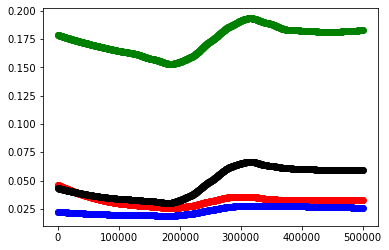

In [120]:
x=list(df.index)

plt.scatter(x, df["brazil"], c="red")
plt.scatter(x, df["tanzania"], c="blue")
plt.scatter(x, df["niger"], c="green")
plt.scatter(x, df["senegal"], c="black")


#plt.plot(dates, values)
plt.show()

In [91]:
%%R

pop_colors <- c("niger"   = "green",
                "senegal"   = "red",
                "brazil"  = "purple",
                "tanzania" = "blue")

#start plotting
p <- ggplot(major_groups, aes(x     = centers, 
                              y     = means, 
                              color = pops))

#adjust colors
p <- p + scale_colour_manual(values = pop_colors)

#plot data
p <- p + geom_point(alpha = 0.0)

#smooth data with loess
p <- p + geom_smooth(span   = 0.75, 
                     method = "loess", 
                     lwd    = 1, 
                     se     = FALSE)

#modify x and y axis
p <- p + scale_x_continuous(name   = "Distance between SNPs (Kb)", 
                            breaks = seq(0,500000,100000), 
                            labels = c("0", "100", "200", "300", "400", "500"), 
                            expand = c(0,0),
                            )
p <- p + scale_y_continuous(name   = "Mean R2", 
                            expand = c(0,0), 
                            limits = c(0,1))

#change theme
p <- p + theme_bw()

#change fonts on axis elements and titles
p <- p + theme(axis.text  = element_text(size = 12),
               axis.title = element_text(size = 14,
                                         face = "bold"))

#removing gridlines
p <- p + theme(panel.grid.major = element_blank(), 
               panel.grid.minor = element_blank())

#set up plot title etc.
p <- p + ggtitle("LD Decay")
p <- p + theme(plot.title = element_text(hjust = 0.5, 
                                         vjust = 0.5, 
                                         face  = 'bold', 
                                          size  = 18))

#modify legend
p <- p + theme(legend.title         = element_text(size = 14, 
                                                   face = "bold"),
               legend.text           = element_text(size = 12),
               legend.position       = c(0.85, 0.85),
               legend.box.background = element_rect(colour = "black"))
p <- p + labs(col = "Population")
p <- p + scale_color_manual(labels = c("Brazil",
                                       "Caribbean",
                                       "E. Africa",
                                       "Oman",
                                       "W. Africa" ), 
                            values = c(pop_colors["brazil_x"], 
                                       pop_colors["caribbean"], 
                                       pop_colors["eafrica"],
                                       pop_colors["oman"],
                                       pop_colors["wafrica"] ))

#save the figure
svg_img <- "results/ld/ld_decay.svg"
png_img <- "results/ld/ld_decay.png"
#ggsave(png_img, plot = p, dpi = 600)
#ggsave(svg_img, plot = p)


#display in notebook
print(p)

R[write to console]: Error in ggplot(major_groups, aes(x = centers, y = means, color = pops)) : 
  could not find function "ggplot"




Error in ggplot(major_groups, aes(x = centers, y = means, color = pops)) : 
  could not find function "ggplot"


In [153]:
#make lists for each population
if not os.path.isdir("results/ld"):
    os.mkdir("results/ld")

ld_pops=["senegal", "niger", "tanzania", "brazil"]

for pop in ld_pops:
    list_file="results/ld/" + pop + ".list"
    with open(list_file, 'w') as filehandle:  
        filehandle.writelines("%s\n" % sample for sample in pop_ids[pop])